In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Since the Listings has a lot of columns, we remove some columns that might be not useful when predicting price, such as url, scrape id. Again, this is from my perspective, of course you can try to fetch those images through the url and treate it as a feature when predicting and you will need some technique to cope with these images.


##### Some reasons why we remove these columns
- 'location': it's the Boston Airbnb information, therefore we don't need this feature.
- 'country': same as location, Boston is in U.S.
- 'review_scores': we only keep the rating scores, since we think the rating scores is the overall information of the lisintg.
- 'square_feet': there are too many NaN in the feature and it's hard to find a method to fill these NaN values.

In [42]:
listings = pd.read_csv('listings.csv')
remove_list = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'experiences_offered', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
               'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'smart_location', 'city', 'state',
               'country_code', 'host_location', 'host_about', 'zipcode', 'host_response_time', 'market', 'country', 'latitude', 'longitude', 'weekly_price', 'extra_people', 'minimum_nights',
               'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
               'availability_365', 'calendar_last_scraped', 'license', 'jurisdiction_names', 'require_guest_profile_picture',
               'reviews_per_month', 'calculated_host_listings_count', 'require_guest_phone_verification', 'first_review', 'last_review',
               'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
               'review_scores_value', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'host_verifications',
               'host_listings_count', 'security_deposit', 'requires_license', 'guests_included', 'neighbourhood_group_cleansed',
               'host_total_listings_count', 'monthly_price', 'square_feet', 'host_since', 'street', 'neighbourhood',
              ]
listings = listings.drop(remove_list, axis=1)
print(listings.columns)
print(len(listings.columns))

Index(['summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'cleaning_fee', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'cancellation_policy'],
      dtype='object')
28


##### Preprocessing Method
- house_rules: turn into length and normalize.

##### Some interesting columns
- minimum_nights: value between 1-300

First we put the text feature aside to quickly bulid a model.

In [43]:
remove_list = ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
              ]
listings = listings.drop(remove_list, axis=1)

In [44]:
cols = listings.columns.to_list()
print(f'We have {len(cols)} columns:', cols)

We have 19 columns: ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'cleaning_fee', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'cancellation_policy']


### Preprocessing

#### Turn the 'f' & 't' into 1, 0

In [45]:
cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable']
for col in cols:
    listings[col] = listings[col].apply(lambda val: 1 if val == 't' else 0)

#### Since the 'price' and 'cleaning_fee' is in string form like '$##.##', we have to extract the correct price.

In [46]:
cols = ['price', 'cleaning_fee']
# fill the NaN in cleaning_fee with '0'
listings['cleaning_fee'] = listings['cleaning_fee'].fillna('0')

for col in cols:
    listings[col] = listings[col].apply(lambda val: float(re.sub(r'[$,]', '', val)) if val != '0' else 0)

# replace the 0 in cleaning_fee with mean
mean = listings['cleaning_fee'].mean()//1
listings['cleaning_fee'] = listings['cleaning_fee'].apply(lambda val: mean if val == 0 else val)

#### FIll the NaN in 'review_scores_rating', 'bathrooms', 'bedrooms', 'beds'

In [47]:
cols = ['review_scores_rating', 'bathrooms', 'bedrooms', 'beds']

for col in cols:
    mean = listings[col].mean()//1
    listings[col] = listings[col].fillna(mean)

#### Rescale the quantitave features

In [48]:
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'number_of_reviews', 'review_scores_rating']


def rescale(df, col, method):
    for col in cols:
        if method == 'norm':
            x = df[col].values.reshape(1, -1)
            x_scaled = preprocessing.normalize(x, norm='l1')
            x_scaled = x_scaled.squeeze()
            df[col] = x_scaled
        else:
            x = df[col].values
            x_scaled = preprocessing.scale(x)
            df[col] = x_scaled            
    return df

listings = rescale(listings, cols, 'norm')

#### Let's deal with the categorical data

In [49]:
def create_dummy_df(df, cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
    '''
    for col in cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [50]:
cols = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']

# handle the NaN in 'property_type' with mode
listings['property_type'] = listings['property_type'].fillna('Apartment')

listings = create_dummy_df(listings, cols, dummy_na=False)

In [51]:
listings['amenities'] = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")])
)
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenity_arr = np.array([listings['amenities'].map(lambda amns: amn in amns) for amn in amenities])
listings = pd.concat([listings, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

In [52]:
listings = listings.drop(['amenities'], axis=1)

In [53]:
listings = listings.query('price <= 300')
X = listings.drop(['price'], axis=1)
y = listings['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

lm_model = LinearRegression(normalize=False)
lm_model.fit(X_train, Y_train)
    
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
    
test_score = r2_score(Y_test, y_test_preds)
train_score = r2_score(Y_train, y_train_preds)

In [15]:
train_score

0.6746449360643039

In [14]:
test_score

0.6815942251708345

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [57]:
coefs = list(zip(lm_model.coef_, listings.drop('price', axis='columns')))

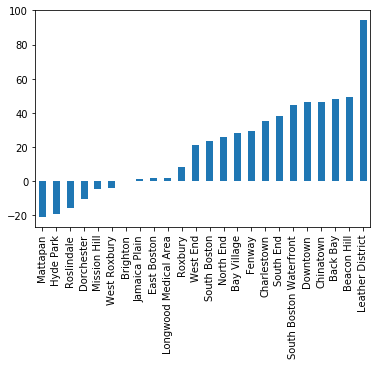

In [58]:
coefs = list(zip(lm_model.coef_, listings.drop('price', axis='columns')))
neighbourhood_effects = [v for v in coefs if v[1].split('_')[0] == 'neighbourhood']
pd.Series(data=[n[0] for n in neighbourhood_effects],
           index=[n[1].split('_')[-1] for n in neighbourhood_effects])\
     .sort_values()\
     .plot(kind='bar')

In [66]:
coefs.sort(reverse=True)
coefs

[(89133.96240321196, 'bedrooms'),
 (73635.51313445771, 'accommodates'),
 (72465.44498471041, 'review_scores_rating'),
 (8726.265823546733, 'beds'),
 (3986.2963834954594, 'cleaning_fee'),
 (94.65006589838049, 'neighbourhood_cleansed_Leather District'),
 (93.07368797568779, 'property_type_Guesthouse'),
 (74.36698413987415, 'cancellation_policy_super_strict_30'),
 (53.91745317636196, 'property_type_Boat'),
 (53.84435895289562, 'property_type_Other'),
 (49.13078800369249, 'neighbourhood_cleansed_Beacon Hill'),
 (48.22383018189407, 'neighbourhood_cleansed_Back Bay'),
 (46.31568017283644, 'neighbourhood_cleansed_Chinatown'),
 (46.30469113823892, 'neighbourhood_cleansed_Downtown'),
 (44.54296363225831, 'neighbourhood_cleansed_South Boston Waterfront'),
 (38.41170016970955, 'neighbourhood_cleansed_South End'),
 (35.222816353765666, 'neighbourhood_cleansed_Charlestown'),
 (29.587249579321906, 'neighbourhood_cleansed_Fenway'),
 (28.506943820014385, 'neighbourhood_cleansed_Bay Village'),
 (25.863